In [1]:
! python servers.py --device cuda:0 --port 5001

^C


In [2]:
import cv2, json ,base64, requests
import numpy as np
from PIL import Image

In [17]:
def random_dark_color():
    return tuple(np.random.randint(0, 200, 3).tolist())

def draw_overlay(image, pts, color):
    overlay = image.copy()
    cv2.fillPoly(overlay, [pts], color)
    alpha = 0.5
    return cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0) 

def draw_rectangle(image, top_left, bottom_right, color, thickness):
    return cv2.rectangle(image, top_left, bottom_right, color, thickness)

def draw_text(image, text, position, color):
    font = cv2.FONT_HERSHEY_SIMPLEX
    return cv2.putText(image, text, position, font, 0.5, color, 2)

def dicplot(pic, dic, version):
    image = pic.copy()
    for key, value in dic.items():
        name = value['name']
        color = random_dark_color()
        # Get bounding box and depth
        xmin, ymin = int(float(value['xmin'])), int(float(value['ymin']))
        xmax, ymax = int(float(value['xmax'])), int(float(value['ymax']))
        deep = int(float(value['deep'])) if 'deep' in value else 'N'

        if version == 'v8':
            # Get keypoints and depth
            pts = np.array(value['keypoints'], np.int32).reshape((-1,1,2))
            # Draw overlay, rectangle and text
            image = draw_overlay(image, pts, color)
            
        if version == 'v5':
            # Draw rectangle and text
            image = draw_rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
            
        image = draw_rectangle(image, (xmin, ymin-20), (xmin + 160, ymin), color, -1)
        image = draw_text(image, f'{name} ds:{deep}', (xmin, ymin-7), (255, 255, 255)) 
            
    return Image.fromarray(image[:,:,::-1])


In [18]:
file = 'Demo.png'
image = cv2.imread(file)
with open(file, "rb") as img_file:
    b64_string = base64.b64encode(img_file.read())

img_base64 = str(b64_string)[2:-1]

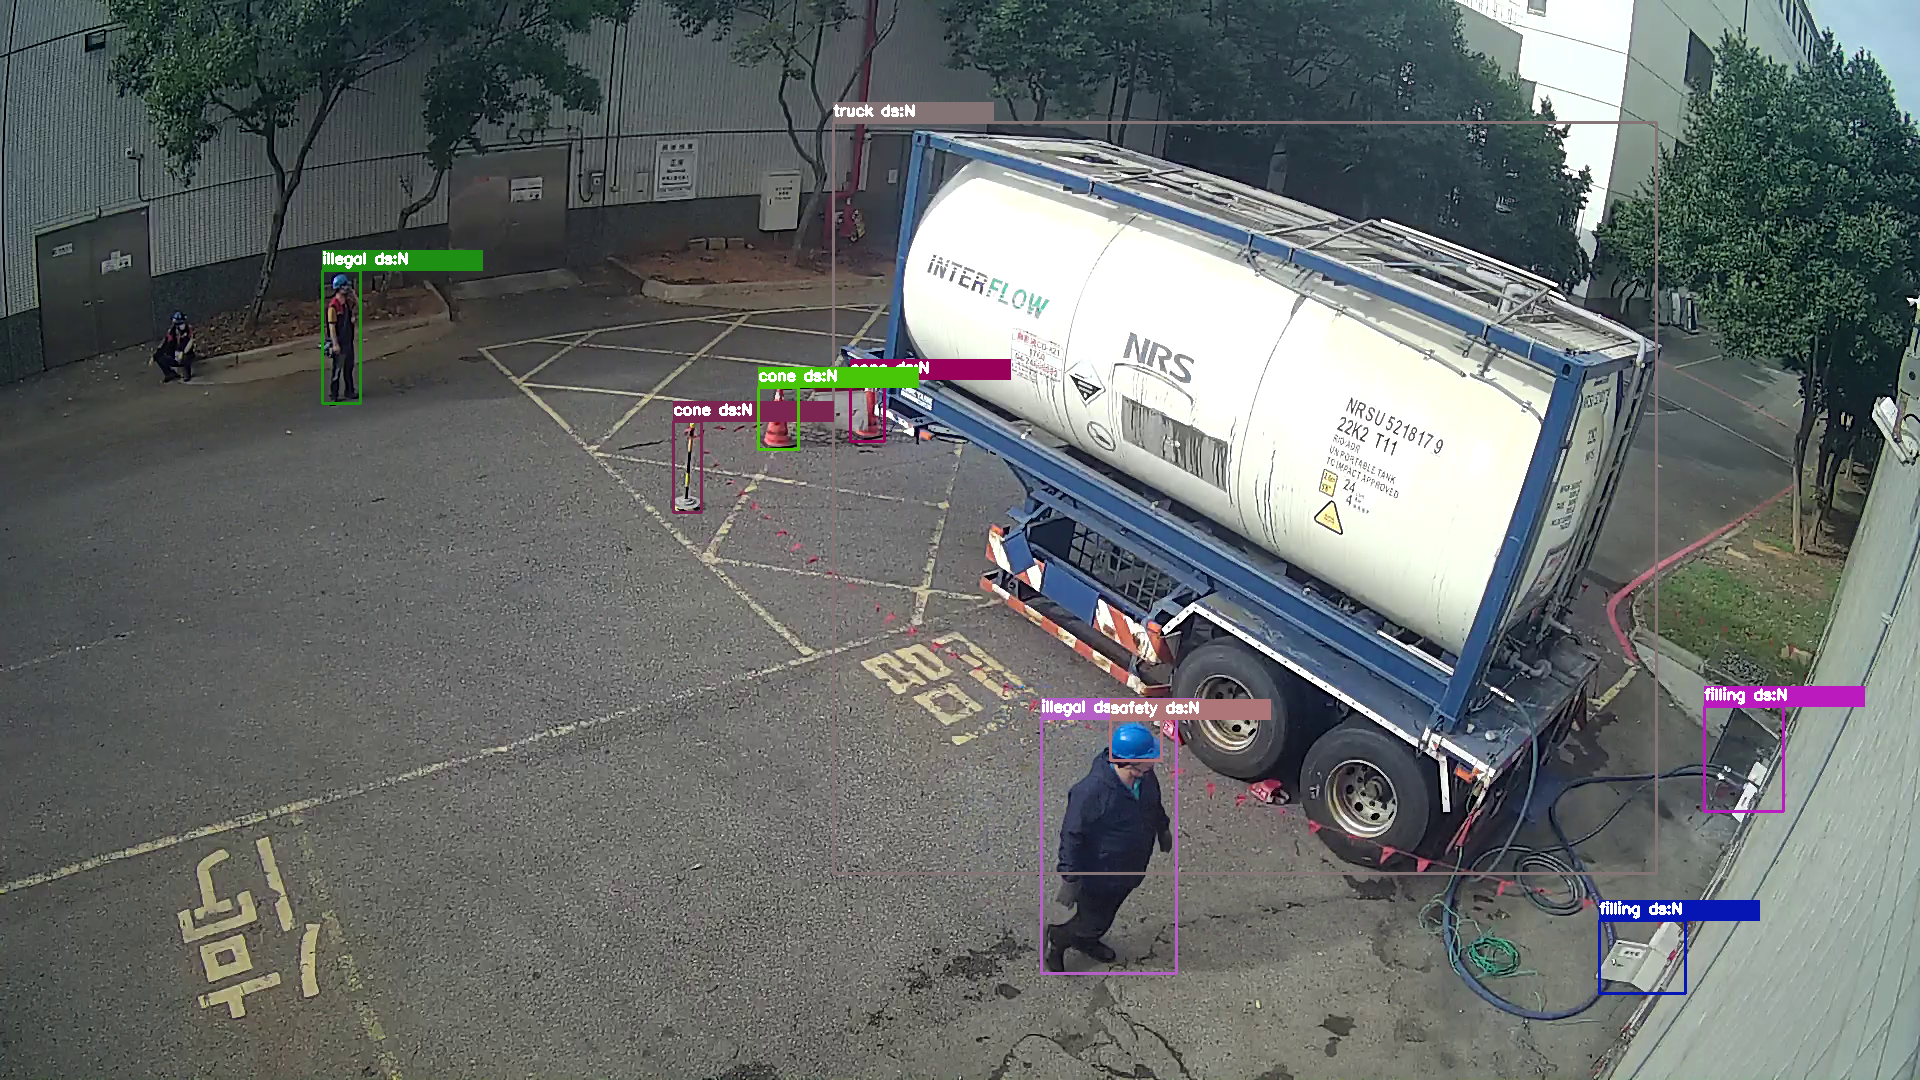

In [19]:
version = 'v5'
Model_name = 'TC3-PPE_Detector_v3.pt'
Deep_model = 'False'

r = requests.post('http://127.0.0.1:5001/upload', 
json = {
    'base64_str':f'{img_base64}',
    'Model_name': Model_name,
    'Deep_model':Deep_model,
    'version':'v5'
})

dic = json.loads(r.text)
dicplot(image,dic,version)

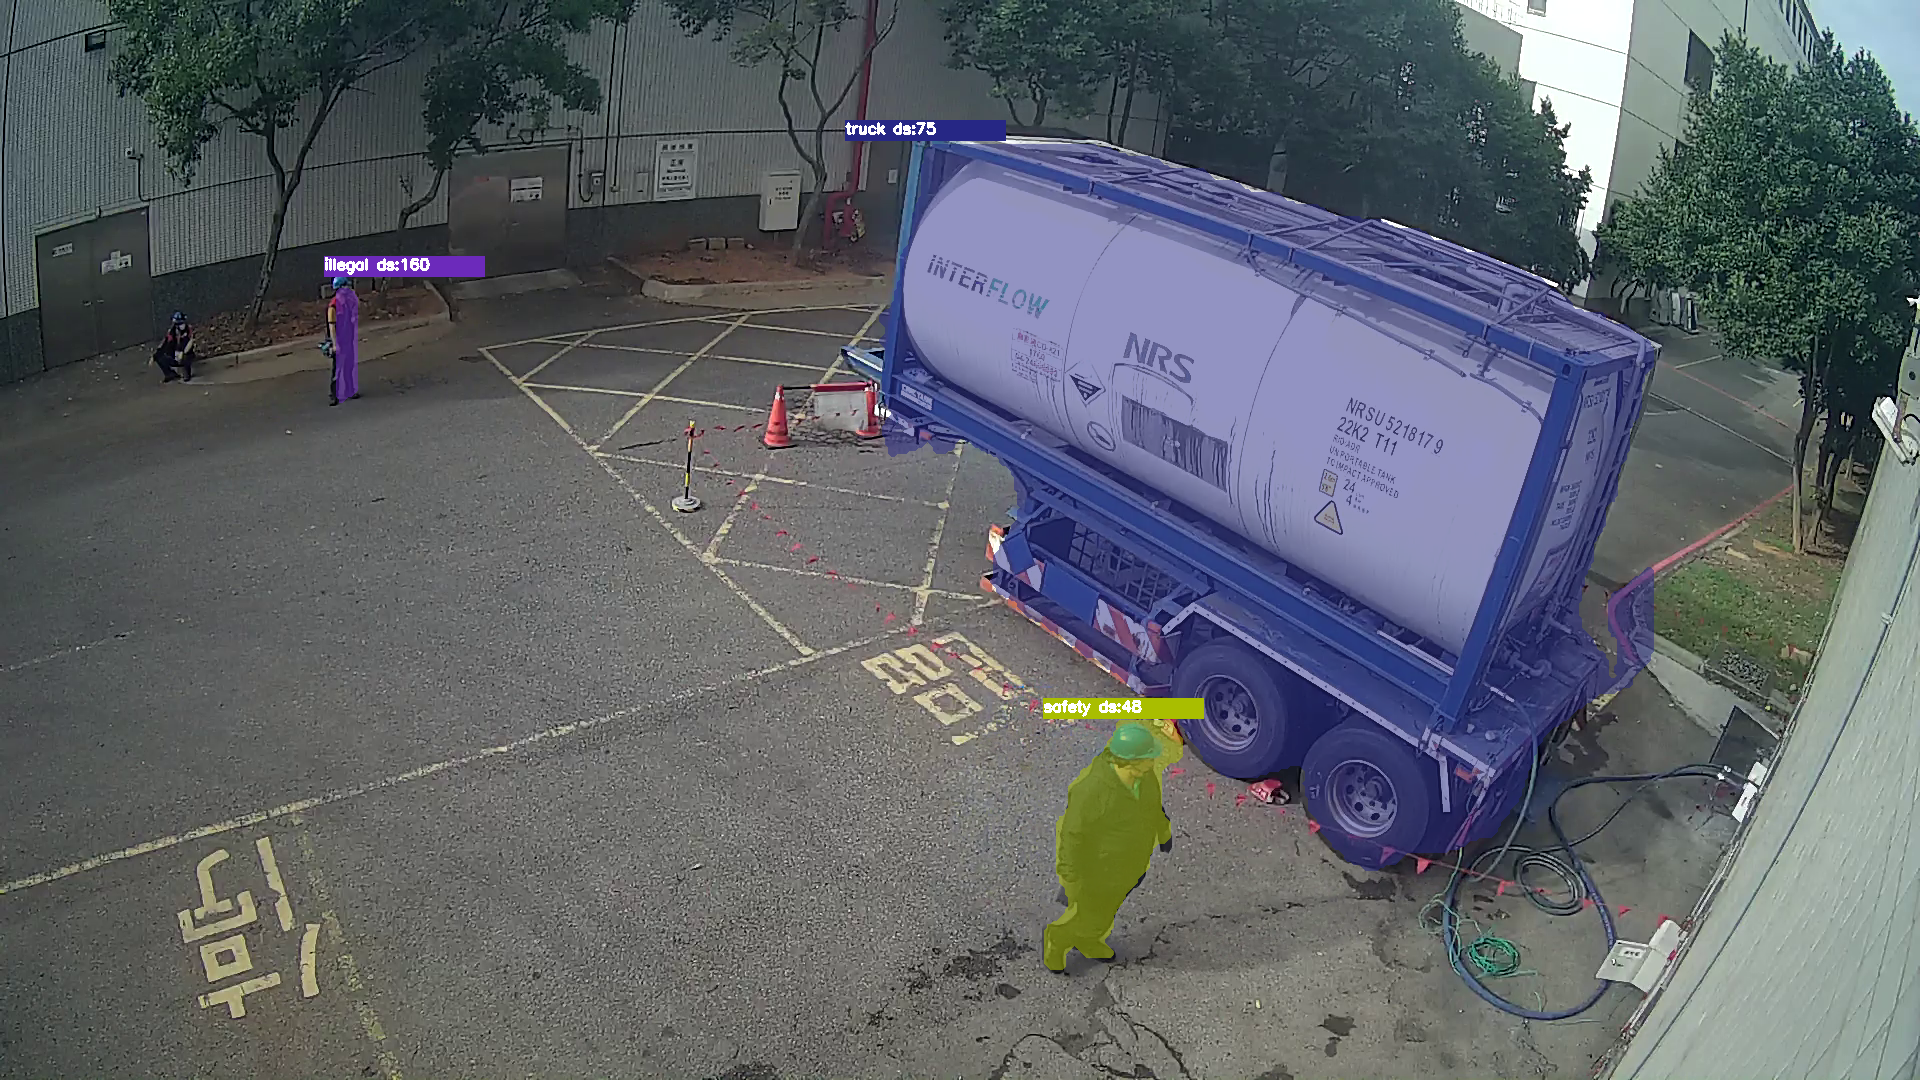

In [20]:
version = 'v8'
Model_name = 'best.pt'
Deep_model = 'True'

r = requests.post('http://127.0.0.1:5001/upload', 
json = {
    'base64_str':f'{img_base64}',
    'Model_name': Model_name,
    'Deep_model':Deep_model,
    'version':version
})

dic = json.loads(r.text)
dicplot(image,dic,version)